In [1]:
from nltk.translate.bleu_score import SmoothingFunction
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import evaluate
rouge = evaluate.load('rouge')

In [ ]:
import random
random.seed(0)

from transformers import AutoTokenizer, AutoModelForCausalLM
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['TRANSFORMERS_CACHE'] = '/home/csgrad/sunilruf/'
path = "/home/csgrad/sunilruf/emotion_chatbot/master/sunils_code/mistra/rank_64/rank_64_2/checkpoint-50/"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path, load_in_4bit=True, device_map="auto")

In [2]:
import json

json_file_path = '../../../ExTES.json'  # Change 'output.json' to your desired file name

# Write the list to the JSON file
with open(json_file_path, 'rb') as json_file:
    extes_data = json.load(json_file)

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/csgrad/sunilruf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import torch
def generate_content(tokenizer, messages):
    input_ids = tokenizer.apply_chat_template(messages, tokenize=True, truncation=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
    tokenizer.pad_token = tokenizer.eos_token
    with torch.no_grad():
        outputs = model.generate(
                input_ids=input_ids,
                pad_token_id=tokenizer.eos_token_id,
                max_new_tokens=128,
                do_sample=True,
                temperature=0.7,
                top_k=50,
                top_p=0.95
        )
        
        val = (tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].split("[/INST]")[-1])
    
    return val, input_ids

In [18]:
import torch
from tqdm import tqdm

max_length = 1024
stride = 128

#encodings = tokenizer.encode_plus(data['dialog'][1]['text'], return_tensors="pt").to('cuda')
tokenizer.pad_token = tokenizer.eos_token
seq_len = 1024


final_nlls = []

final_nlls_boh = []
prev_end_loc = 0
messages = []
i = 1
final_messages = []
final_messages_boh = []
final_messages_boh1 = []
final_perplexity = []
final_perplexity_boh = []
bleu_final, bleu_boh_final = [], []
rouge_1_final, rouge_2_final, rougle_l_final = [], [], []
Bert_P_final, Bert_R_final, Bert_F1_final = [], [], []
rouge_1_boh_final, rouge_2_boh_final, rougle_l_boh_final = [], [], []
Bert_P_boh_final, Bert_R_boh_final, Bert_F1_boh_final = [], [], []
for j in range(10):
    num = random.choice(range(3000, 3100))
    #num = 10000
    data = extes_data[num]['content']
    perplexity = []
    perplexity_boh = []
    nlls = []
    nlls_boh = []
    #data = data
    messages = []
    messages_boh = []
    messages_boh1 = []
    bleu_1, bleu_1_boh = [], []
    rouge_1, rouge_2, rougle_l = [], [], []
    Bert_P, Bert_R, Bert_F1 = [], [], []
    rouge_1_boh, rouge_2_boh, rougle_l_boh = [], [], []
    Bert_P_boh, Bert_R_boh, Bert_F1_boh = [], [], []
    try:
        for i in range(0, len(data), 2):
            for begin_loc in (range(0, seq_len, stride)):
                print(data[i])
                messages.append({"role": "user", "content":  data[i]['User']})
                messages_boh.append({"role": "user", "content":  remove_stopwords(data[i]['User'])})
                messages_boh1.append({"role": "user", "content":  data[i]['User']})
                i+=2
                end_loc = min(begin_loc + max_length, seq_len)
                trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
                #input_ids = encodings.input_ids[:, begin_loc:end_loc].to('cuda')
                input_ids = tokenizer.apply_chat_template(messages, tokenize=True, truncation=False, add_generation_prompt=True, return_tensors="pt").to("cuda")
                input_ids_boh = tokenizer.apply_chat_template(messages_boh, tokenize=True, truncation=False, add_generation_prompt=True, return_tensors="pt").to("cuda")
                target_ids = input_ids.clone()
                target_ids_boh = input_ids_boh.clone()
                target_ids[:, :-trg_len] = -100
                target_ids_boh[:, :-trg_len] = -100

                with torch.no_grad():
                    
                    
                    val, _ = generate_content(tokenizer, messages)
                    val_boh, _ = generate_content(tokenizer, messages_boh)
                    candidate = val
                    candidate_boh = val_boh
                    reference = data[i]['AI']
                    references = data[i]['AI'].split(" ")
                    candidates = val.split(" ")
                    candidates_boh = val_boh.split(" ")
                    outputs = model(input_ids, labels=target_ids)
                    print(val)
                    print(val_boh)
                    messages.append({"role": "assistant", "content": val})
                    print(outputs.logits.shape)
                    outputs_boh = model(input_ids_boh, labels=target_ids_boh)
                    print(outputs_boh.logits.shape)
                    messages_boh.append({"role": "assistant", "content": remove_stopwords(val_boh)})
                    messages_boh1.append({"role": "assistant", "content": val_boh})
                        
                    
                    neg_log_likelihood = outputs.loss
                    neg_log_likelihood_boh = outputs_boh.loss
                    
                    bleu_1.append(sentence_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=smoothie))
                    results = rouge.compute(predictions=[candidate], references=[reference])
                    rouge_1.append(results['rouge1'])
                    rouge_2.append(results['rouge2'])
                    rougle_l.append(results['rougeL'])
                    
                    P, R, F1 = score([candidate], [reference], lang='en', model_type='bert-base-uncased')
                    Bert_P.append(P)
                    Bert_R.append(R)
                    Bert_F1.append(F1)
                    
                    bleu_1_boh.append(sentence_bleu(references, candidates_boh, weights=(1, 0, 0, 0), smoothing_function=smoothie))
                    results_boh = rouge.compute(predictions=[candidate_boh], references=[reference])
                    rouge_1_boh.append(results_boh['rouge1'])
                    rouge_2_boh.append(results_boh['rouge2'])
                    rougle_l_boh.append(results_boh['rougeL'])
                    
                    P, R, F1 = score([candidate_boh], [reference], lang='en', model_type='bert-base-uncased')
                    Bert_P_boh.append(P)
                    Bert_R_boh.append(R)
                    Bert_F1_boh.append(F1)
                    #print(neg_log_likelihood.shape)

                nlls.append(neg_log_likelihood)
                nlls_boh.append(neg_log_likelihood_boh)
                #print(len(nlls))
                prev_end_loc = end_loc
                if end_loc == seq_len:
                    break

            ppl = torch.exp(torch.stack(nlls).mean())
            ppl_boh = torch.exp(torch.stack(nlls_boh).mean())
            print(ppl)
            print(ppl_boh)
            perplexity.append(ppl)
            perplexity_boh.append(ppl_boh)
            
    except:
        print(num)
    
    final_perplexity.append(perplexity)
    final_perplexity_boh.append(perplexity_boh)
    final_nlls.append(nlls)
    final_nlls_boh.append(nlls_boh)
    final_messages.append(messages)
    final_messages_boh.append(messages_boh)
    final_messages_boh1.append(messages_boh1)
    bleu_final.append(bleu_1)
    rouge_1_final.append(rouge_1)
    rouge_2_final.append(rouge_2)
    rougle_l_final.append(rougle_l)
    Bert_P_final.append(Bert_P)
    Bert_R_final.append(Bert_R)
    Bert_F1_final.append(Bert_F1)
    bleu_boh_final.append(bleu_1_boh)
    rouge_1_boh_final.append(rouge_1_boh)
    rouge_2_boh_final.append(rouge_2_boh)
    rougle_l_boh_final.append(rougle_l_boh)
    Bert_P_boh_final.append(Bert_P_boh)
    Bert_R_boh_final.append(Bert_R_boh)
    Bert_F1_boh_final.append(Bert_F1_boh)

{'User': "Hey, I need to talk to someone about a problem I'm having."}
 Hello there! I'm here to listen. What seems to be the issue?
 Hello! I'm here to listen. What's been going on?
torch.Size([1, 24, 32000])
torch.Size([1, 19, 32000])
tensor(6.3211, device='cuda:0')
tensor(40.0023, device='cuda:0')
{'User': "Lately, I've noticed that my close friend and I are having more and more misunderstandings and arguments. It's really putting a strain on our friendship."}
 I'm sorry to hear that. It sounds like there's a lot of tension between you and your friend. Can you tell me more about what's been happening?
I'm sorry to hear that. It sounds like your friendships are facing some challenges right now. Can you tell me more about what's been happening?
torch.Size([1, 84, 32000])
torch.Size([1, 59, 32000])
tensor(4.4034, device='cuda:0')
tensor(31.0021, device='cuda:0')
{'User': "Sure. It feels like we're constantly misinterpreting each other's intentions. We end up getting defensive and it ju

In [19]:
print(len(final_perplexity))

10


In [20]:
for i in range(10):
    print(final_perplexity[i])
    print(final_perplexity_boh[i])
    print("#################")

[tensor(6.3211, device='cuda:0'), tensor(4.4034, device='cuda:0'), tensor(3.5555, device='cuda:0'), tensor(3.1800, device='cuda:0'), tensor(2.9625, device='cuda:0'), tensor(2.8258, device='cuda:0'), tensor(2.7418, device='cuda:0'), tensor(2.6780, device='cuda:0'), tensor(2.6206, device='cuda:0'), tensor(2.5694, device='cuda:0'), tensor(2.5245, device='cuda:0')]
[tensor(40.0023, device='cuda:0'), tensor(31.0021, device='cuda:0'), tensor(25.0536, device='cuda:0'), tensor(22.6727, device='cuda:0'), tensor(21.6198, device='cuda:0'), tensor(20.8947, device='cuda:0'), tensor(20.5919, device='cuda:0'), tensor(20.2801, device='cuda:0'), tensor(19.9588, device='cuda:0'), tensor(19.5321, device='cuda:0'), tensor(19.1520, device='cuda:0')]
#################
[tensor(5.0612, device='cuda:0'), tensor(4.0789, device='cuda:0'), tensor(3.5223, device='cuda:0'), tensor(3.2083, device='cuda:0'), tensor(3.0342, device='cuda:0'), tensor(2.9253, device='cuda:0')]
[tensor(90.0922, device='cuda:0'), tensor(64

In [21]:
for i in range(9,10):
    for j in range(len(final_messages[i])):
        print(final_messages[i][j])
        print(final_messages_boh1[i][j])
        print("#################")

{'role': 'user', 'content': "Hey, I really need to talk about something that's been bothering me."}
{'role': 'user', 'content': "Hey, I really need to talk about something that's been bothering me."}
#################
{'role': 'assistant', 'content': " Hello, I'm here for you. Please feel free to express whatever is on your mind."}
{'role': 'assistant', 'content': " Hi there! I'm here to listen and support you. What's been going on that you need to talk about?"}
#################
{'role': 'user', 'content': "Well, my best friend and I had a disagreement about attending a mutual friend's wedding. I wanted to go, but my best friend had some reservations, and we ended up arguing about it."}
{'role': 'user', 'content': "Well, my best friend and I had a disagreement about attending a mutual friend's wedding. I wanted to go, but my best friend had some reservations, and we ended up arguing about it."}
#################
{'role': 'assistant', 'content': " I can understand how that disagreement

In [25]:
perplexity_final_list = []
perplexity_boh_final_list = []
for i in range(10):
    perplexity = [tensor.tolist() for tensor in final_perplexity[i]]
    perplexity_boh = [tensor.tolist() for tensor in final_perplexity_boh[i]]
    perplexity_final_list.append(perplexity)
    perplexity_boh_final_list.append(perplexity_boh)

print(perplexity_final_list)


[[6.321129322052002, 4.403414726257324, 3.5555222034454346, 3.1800003051757812, 2.962514877319336, 2.825831413269043, 2.7417614459991455, 2.678008556365967, 2.6205801963806152, 2.5694329738616943, 2.5245442390441895], [5.06122350692749, 4.078860759735107, 3.5223472118377686, 3.2083184719085693, 3.034189462661743, 2.925312042236328], [5.968179225921631, 4.0045013427734375, 3.381249189376831, 3.1352710723876953, 2.9649553298950195], [4.31005859375, 3.357438325881958, 2.9124059677124023, 2.732555866241455, 2.624377965927124, 2.566269636154175, 2.5446996688842773, 2.532721757888794], [5.04195499420166, 3.6313211917877197, 3.330120325088501, 3.1066558361053467, 2.991071939468384, 2.9288127422332764, 2.8563404083251953, 2.793278455734253, 2.7440719604492188, 2.7126212120056152, 2.6778173446655273], [4.300247669219971, 3.4130120277404785, 2.9807488918304443, 2.8123340606689453, 2.679966449737549, 2.578935384750366, 2.5318782329559326, 2.4931960105895996], [6.0145134925842285, 4.16412353515625

In [28]:
perplexity_final_list_filtered = []
perplexity_boh_final_list_filtered = []
for i in range(10):
    #print(len(perplexity_final_list[i]))
    #print(len(perplexity_boh_final_list[i]))
    if len(perplexity_final_list[i]) == 8:
        perplexity_final_list_filtered.append(perplexity_final_list[i])
    if len(perplexity_boh_final_list[i]) == 8:
        perplexity_boh_final_list_filtered.append(perplexity_boh_final_list[i])

In [41]:
import numpy as np

perplexity_final_list_filtered = np.array(perplexity_final_list_filtered)
perplexity_boh_final_list_filtered = np.array(perplexity_boh_final_list_filtered)

print(np.mean(np.mean(perplexity_final_list_filtered, axis=1)))
print(np.mean(np.mean(perplexity_boh_final_list_filtered, axis=1)))

3.2516173720359802
34.62467074394226


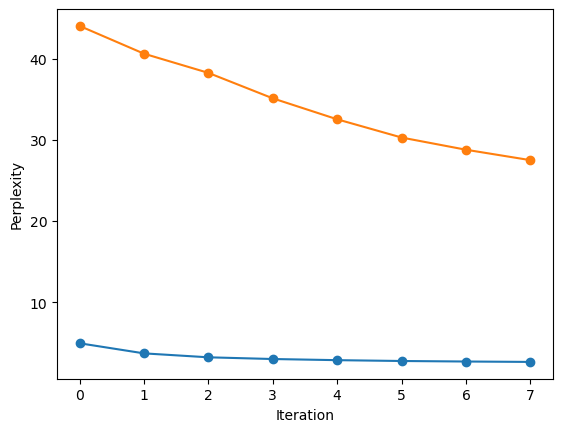

In [38]:
import matplotlib.pyplot as plt
import numpy as np
x_values = list(range(len(perplexity_final_list_filtered)))

# Plot the line graph
plt.plot(np.mean(perplexity_final_list_filtered, axis=0), marker='o', label='Perplexity')
plt.plot(np.mean(perplexity_boh_final_list_filtered, axis=0), marker='o', label='Perplexity (BOH)')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
#plt.title('Perplexity of Final List (BOH)')

# Show the plot
plt.show()


In [39]:

np.save('perplexity_scores/mistral/mistral_tuned.npy', perplexity_final_list_filtered)
np.save('perplexity_scores/mistral/mistral_tuned_boh.npy', perplexity_boh_final_list_filtered)
